**Step 1 — Install Dependencies**

In [ ]:
!pip install transformers datasets evaluate accelerate scikit-learn seaborn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


**Step 2 — Imports + Reproducibility**

In [ ]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


**Step 3 — Load Dataset (AG News)**

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

dataset


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

**Split validation from training**

In [ ]:
dataset = dataset["train"].train_test_split(test_size=0.1)

train_ds = dataset["train"]
val_ds = dataset["test"]
test_ds = load_dataset("ag_news", split="test")


**✅ Step 4 — Tokenization**

In [ ]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

**Format for PyTorch**

In [ ]:
cols = ["input_ids", "attention_mask", "label"]

train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)


**Step 5 — Load Model**

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=4
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


**Move to GPU**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**Step 6 — Metrics**

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }


**Step 7 — Training Configuration**

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_agnews",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True  # Huge speed boost on GPU
)

**Step 8 — Trainer API**

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

**Step 9 — Train**

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.226476,0.184892,0.943500,0.943536
2,0.135849,0.182185,0.948000,0.948114
3,0.085623,0.219803,0.948583,0.948622


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=20250, training_loss=0.14931590892650462, metrics={'train_runtime': 4306.0261, 'train_samples_per_second': 75.243, 'train_steps_per_second': 4.703, 'total_flos': 4.2624756375552e+16, 'train_loss': 0.14931590892650462, 'epoch': 3.0})

**Step 10 — Test Evaluation**

In [ ]:
trainer.evaluate(test_ds)


{'eval_loss': 0.22884617745876312,
 'eval_accuracy': 0.9481578947368421,
 'eval_f1': 0.9481744374276363,
 'eval_runtime': 29.1985,
 'eval_samples_per_second': 260.288,
 'eval_steps_per_second': 8.151,
 'epoch': 3.0}

**Step 11 — Classification Report**

In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_ds)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print(classification_report(labels, preds))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1900
           1       0.99      0.99      0.99      1900
           2       0.92      0.91      0.92      1900
           3       0.92      0.93      0.93      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600



**Step 12 — Confusion Matrix Visualization**

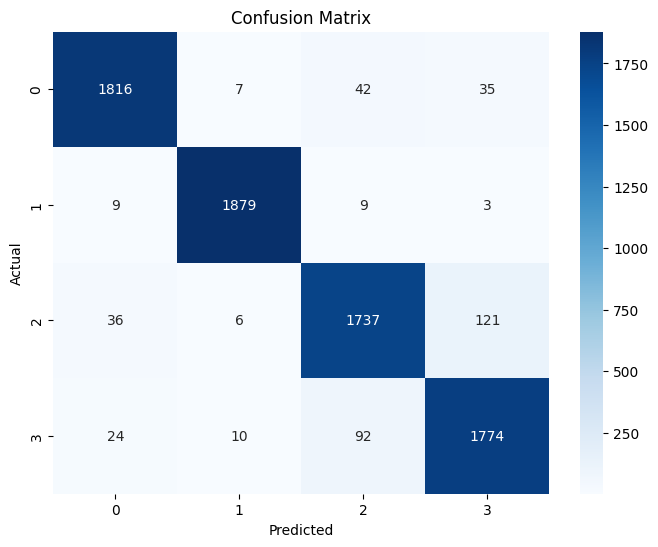

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**Step 13 — Misclassification Analysis**

In [ ]:
from datasets import load_dataset

# Reload the test dataset to access the original 'text' column
original_test_ds = load_dataset("ag_news", split="test")
texts = original_test_ds["text"]

misclassified = []

for text, pred, label in zip(texts, preds, labels):
    if pred != label:
        misclassified.append((text, pred, label))

for i in range(10):
    print("\nTEXT:", misclassified[i][0][:300])
    print("PRED:", misclassified[i][1])
    print("TRUE:", misclassified[i][2])


TEXT: Some People Not Eligible to Get in on Google IPO Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open process with 28 underwriters - all this pointed to a n
PRED: 2
TRUE: 3

TEXT: Venezuela Prepares for Chavez Recall Vote Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market.
PRED: 2
TRUE: 0

TEXT: Promoting a Shared Vision As Michael Kaleko kept running into people who were getting older and having more vision problems, he realized he could do something about it.
PRED: 2
TRUE: 3

TEXT: Intel to delay product aimed for high-definition TVs SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown with Texas Instruments Inc. in the fast-